# example-ct-to-stl.ipynb

This notebook performs the segmentation workflow adapted for the compressed F50 sand experiment and adds a step to convert the segmented voxels to tri-meshes to be saved as STLs.

Note: this notebook takes inputs from a YAML file like [segmentflow-input.yml](segmentflow-input.yml). Try running with the example settings in that file (after changing the path to the CT images) or leave fields blank to use default values.

# Import packages

In [1]:
import imageio.v3 as iio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import open3d as o3d
from pathlib import Path
import pandas as pd
import segment
from scipy import ndimage as ndi
from skimage import (
        color, feature, filters, morphology, measure, segmentation, util)
from stl import mesh
import sys
import yaml
%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Load 3D data

Value for "Segmentation Plot Number of Images" not provided. Setting to default value: 3
Loading images...
Loading images...
--> Images loaded as 3D array:  (100, 1024, 1004)
--> Images loaded as 3D array: (100, 1024, 1004)
Plotting images: [0, 25, 50, 75]


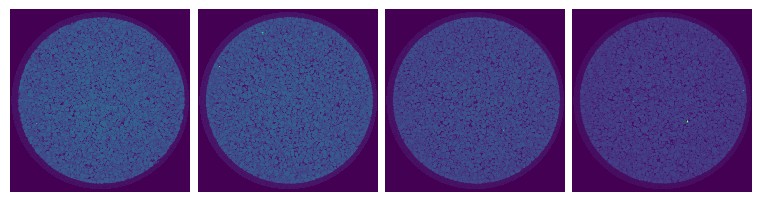

In [2]:
# Load YAML inputs into ui dictionary
yaml_path = Path('segmentflow-input.yml')
ui = segment.load_inputs(yaml_path)
# Load images as 3D array from a directory containing images
print('Loading images...')
imgs = segment.load_images(
        ui['ct_img_dir'],
        slice_crop=ui['slice_crop'],
        row_crop=ui['row_crop'], 
        col_crop=ui['col_crop'],
        file_suffix=ui['file_suffix'])
print(f'--> Images loaded as 3D array: {imgs.shape}')
# Plot images
fig, axes = segment.plot_imgs(imgs, n_imgs=4)
plt.show()

## Preprocess images

Preprocessing images...
Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [5, 95]...
--> Preprocessing complete
--> Preprocessing complete.
Plotting images: [0, 25, 50, 75]


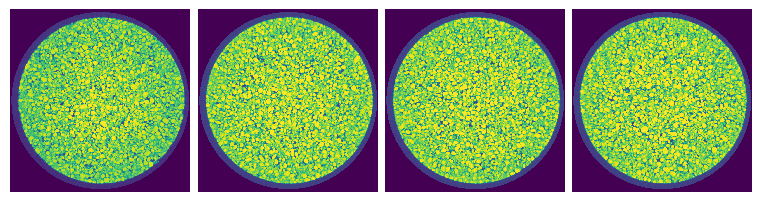

In [3]:
print('Preprocessing images...')
imgs_pre = segment.preprocess(
        imgs, 
        median_filter=ui['pre_seg_med_filter'], 
        rescale_intensity_range=ui['rescale_range'])
print('--> Preprocessing complete.')
# Plot preprocessed images
fig, axes = segment.plot_imgs(imgs_pre, n_imgs=4)
plt.show()

## Binarize images

Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.
Plotting images: [0, 25, 50, 75]


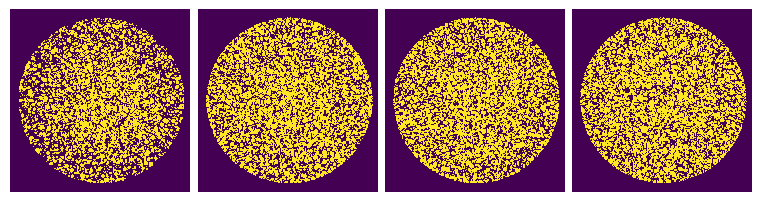

In [4]:
# Binarize images
imgs_binarized, thresh_vals = segment.binarize_multiotsu(
        imgs_pre, n_otsu_classes=ui['n_otsu_classes'], 
        n_selected_thresholds=ui['n_selected_classes'])
# Plot preprocessed images
fig, axes = segment.plot_imgs(imgs_binarized, n_imgs=4)
plt.show()

## Segment images

Segmenting images...
--> Number of particle(s) before border exclusion:  8821
--> Excluding border particles...
--> Segmentation complete. 5657 particle(s) segmented.
Plotting images: [25, 50, 75]


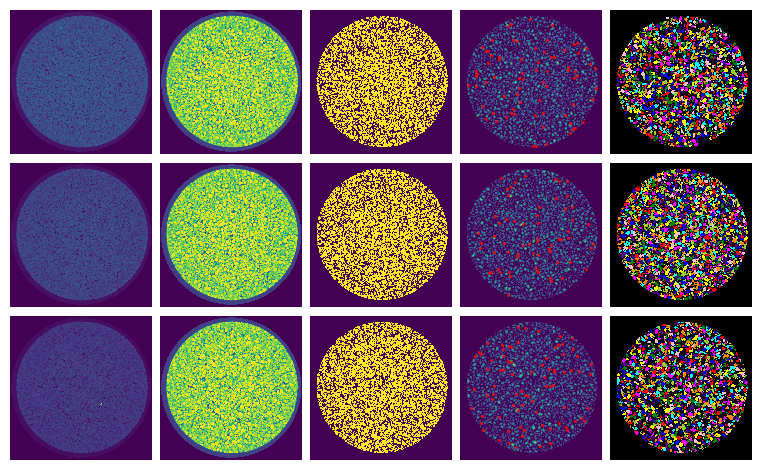

In [6]:
# Segment images
segment_dict = segment.watershed_segment(
        imgs_binarized, 
        min_peak_distance=ui['min_peak_dist'], 
        use_int_dist_map=ui['use_int_dist_map'], 
        exclude_borders=ui['exclude_borders'], 
        return_dict=True)
# Plot segmentation results
fig, axes = segment.plot_segment_steps(
        imgs, imgs_pre, imgs_binarized, segment_dict, 
        slices=ui['seg_fig_slices'])
plt.show()

## Save STL for each grain

Generating surface meshes...
Surface mesh not created for particle 938: No surface found at the given iso value.
Surface mesh not created for particle 995: No surface found at the given iso value.
Surface mesh not created for particle 1005: Particle smaller than minimum width in at least one dimension.
Surface mesh not created for particle 1011: Particle smaller than minimum width in at least one dimension.
Surface mesh not created for particle 1059: No surface found at the given iso value.
Surface mesh not created for particle 1085: No surface found at the given iso value.
Surface mesh not created for particle 1129: No surface found at the given iso value.
Surface mesh not created for particle 1130: No surface found at the given iso value.
Surface mesh not created for particle 1189: No surface found at the given iso value.
Surface mesh not created for particle 1239: No surface found at the given iso value.
Surface mesh not created for particle 1266: No surface found at the given iso v

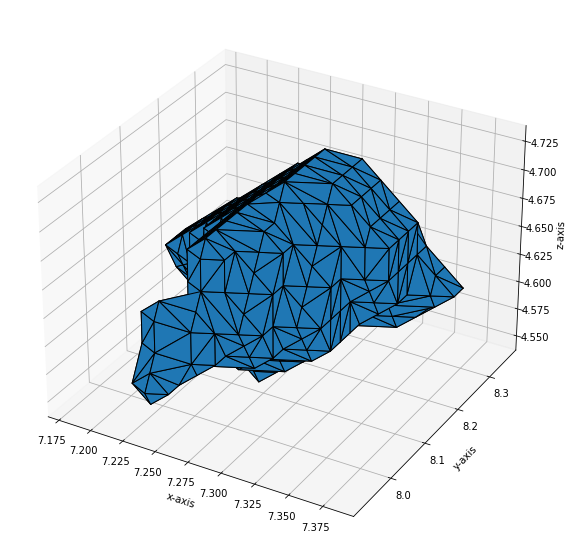

In [7]:
if ui['create_stls']:
    segment.save_as_stl_files(
            segment_dict['integer-labels'],
            ui['stl_dir_location'],
            ui['output_fn_base'],
            suppress_save_msg=ui['suppress_save_msg'],
            slice_crop=ui['slice_crop'],
            row_crop=ui['row_crop'],
            col_crop=ui['col_crop'],
            stl_overwrite=ui['stl_overwrite'],
            spatial_res=ui['spatial_res'],
            n_erosions=ui['n_erosions'],
            median_filter_voxels=ui['post_seg_med_filter'],
            voxel_step_size=ui['voxel_step_size'])
    fig, ax = segment.plot_stl(ui['stl_dir_location'], zoom=True)
    plt.show()

## Postprocess surface meshes for each particle


Postprocessing surface meshes...
--> 5563 surface meshes postprocessed.
Plotting STL: F63_300-400_3220.stl


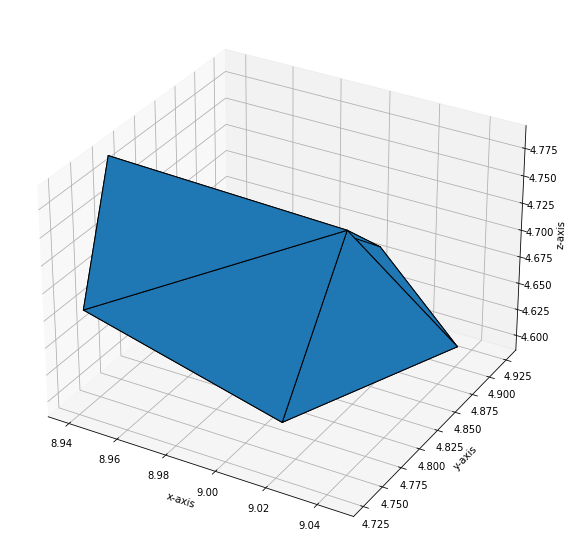

In [8]:
if (
        ui['mesh_smooth_n_iters'] is not None
        or ui['mesh_simplify_n_tris'] is not None
        or ui['mesh_simplify_factor'] is not None):
    print()
    # Iterate through each STL file, load the mesh, and smooth/simplify
    segment.postprocess_meshes(
            ui['stl_dir_location'], 
            smooth_iter=ui['mesh_smooth_n_iters'], 
            simplify_n_tris=ui['mesh_simplify_n_tris'], 
            iterative_simplify_factor=ui['mesh_simplify_factor'], 
            recursive_simplify=False, resave_mesh=True)
    fig, ax = segment.plot_stl(ui['stl_dir_location'], zoom=True)
    plt.show()